# Assignment 1
### Date: 03/10/2020
#### Bjørn Blirup Cilleborg (nvf696)

This assignment consists of exercises from class 1 through 3. The following exercises will be solved in this assignment:

- Exercise 1.1.8
- Exercise 2.1.1
- Exercise 2.1.2
- Exercise 2.1.3
- Exercise 3.1.2

## Exercise 1
### Exercise 1.1.8

This exercise is about cross-validation which is used to optimize the model. In particular, we make sure of a nested resampling to further optimize or model based on the data.

We use the preamble available to us from exercise 1 and use it to import the lending data and sort the data.

In [4]:
#Preamble:

# Note: there are three .zip files with letter = a,b,c. 
# To ensure the files download in reasonable time we 
# only work with the first of the three. If you have time
# you can modify this cell to download all three. 

# IMPORTS
import os
import requests

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit

# CODE
filenames = []
base_url = 'https://resources.lendingclub.com/'

letter = 'a'
filename = f'LoanStats3{letter}.csv.zip'
url = base_url+filename

if not os.path.exists(filename):
    r = requests.get(url, allow_redirects=True)
    open(filename, 'wb').write(r.content)
filenames.append(filename)


# Read in csv files, store them
dfs = [pd.read_csv(f,header=0,skiprows=1,low_memory=False) for f in filenames]

# concatenate the dataframes (as standard there is only 1)
df = pd.concat(dfs)\
        .dropna(subset=['loan_amnt'])\
        .dropna(axis=1, how='all')

# View data
df.head()

# Identify loans of interest
df = df.loc[df.loan_status.isin(['Fully Paid', 'Charged Off'])].copy()

# Clean up variables 
df['charged_off'] = (df.loan_status=='Charged Off').astype(int)
df['int_rate_f'] = df.int_rate.str[:-1].astype(float)
df['emp_length_f'] = df.emp_length\
                        .str.split(' ')\
                        .str[0].str[:2]\
                        .str.replace('<','0')\
                        .astype(float)

# label and features
y_var = 'charged_off'
X_vars = ['term', 'int_rate_f', 'grade', 'home_ownership', 'emp_length_f',
          'annual_inc', 'verification_status', 'dti']

# Create dummies
data = pd.get_dummies(df[X_vars+[y_var]], drop_first=True)\
        .dropna()\
        .reset_index(drop=True)\
        .astype(np.float64)\
        .loc[:2000]\
        .copy()

# View data
data.head()

sss = StratifiedShuffleSplit(n_splits=10, test_size=.3, random_state=3)

# These are the row indices of the stratified split
data_splits = list(sss.split(data[y_var], data[y_var]))

# Separate data in y,X
y = data[y_var]
X_vars_b = data.columns!=y_var
X = data.loc[:,X_vars_b]

First we import the solution to **Exercise 1.1.1, 1.1.2, 1.1.4, 1.1.7** as this is used as basis for performing the k-fold cross-validation. 

In [24]:
# IMPORTS 
from sklearn.preprocessing import StandardScaler        # scales variables to be mean=0,sd=1
from sklearn.linear_model import LogisticRegression     # regression model
from sklearn.pipeline import Pipeline                   # For building our model pipeline
from sklearn.metrics import f1_score, accuracy_score    # for accuracy scores
from sklearn.model_selection import GridSearchCV        # Cross-validation grid search

# Exercise 1.1.1 
train_idx, test_idx = data_splits[0]

y_train = y.loc[train_idx]
X_train = X.loc[train_idx]

y_test = y.loc[test_idx]
X_test = X.loc[test_idx]

# Exercise 1.1.2
lr = Pipeline([('scale', StandardScaler()),
               ('clf', LogisticRegression(class_weight='balanced',C=10**10, solver = 'liblinear'))])

lr.fit(X_train, y_train)
y_p_tr = lr.predict(X_train)
acc_tr, f1_tr = accuracy_score(y_p_tr,y_train), f1_score(y_p_tr,y_train)
acc_tr,f1_tr

# Exercise 1.1.4
y_p_ts = lr.predict(X_test)
acc_tst, f1_tst = accuracy_score(y_p_ts,y_test), f1_score(y_p_ts,y_test)
acc_tst, f1_tst

# Exercise 1.1.7
lr_cv = GridSearchCV(estimator=lr,
                     param_grid={'clf__C':np.logspace(-4,4,5)},
                     n_jobs=-1,
                     cv=3)
lr_cv.fit(X_train, y_train)

y_p_tst_cv = lr_cv.predict(X_test)
acc_tst_cv = accuracy_score(y_p_tst_cv, y_test)
f1_tst_cv = f1_score(y_p_tst_cv, y_test)
acc_tst_cv, f1_tst_cv

(0.6339434276206323, 0.3373493975903615)

> **Ex. 1.1.8:** Apply nested resampling to compute a distribution of test scores with and without optimization. You should use `data_splits` which we defined initially and input all the data.
>
>> *Hint:* You can implement this using your code from Ex. 1.1.6 and combine it with `cross_val_score`. Note that `cv` input should use `data_splits`. See Raschka pp. 188-189 for inspiration. 


In [44]:
# Inspiration from Rascha page 188-189
# We use the length of the list data_splits as input for our cross-validation
# We calculate scores based on both non-optimized and optimized
from sklearn.model_selection import cross_val_score

# Non-optimized
scores = cross_val_score(estimator=lr,
                        X = X_train,
                        y = y_train,
                        cv = len(data_splits),
                        n_jobs = 1)

# Optimized 
scores_cv = cross_val_score(estimator=lr_cv,
                        X = X_train,
                        y = y_train,
                        cv = len(data_splits),
                        n_jobs = 1)
print('Non-optimized accuracy scores mean and standard deviation: %s' % 
      np.round(np.mean(scores),2), np.round(np.std(scores),2))
print('Cross-validated optimized accuracy scores mean and standard deviation: %s' %
      np.round(np.mean(scores_cv),2), np.round(np.std(scores_cv),2))

Non-optimized accuracy scores mean and standard deviation: 0.65 0.07
Cross-validated optimized accuracy scores mean and standard deviation: 0.65 0.06


From our model we see that the cross-validation accuracy score has an average of 0.65 for both non-optimized and optimized using grid search and a standard deviation of 0.07 for the non-optimizd and 0.06 for the optimized.
This suggests that the using gridsearch to tune the hyperparameter reduces the standard deviation of the accuracy scores, which makes it preferrable. 
This score gives us an idea about how tuning of hyperparameters can affect the the model. The benefit of using cross-validation is that even though it is computationally expensive it makes great use of the available data. Therefore if a limited amount of data is available using cross-validation might be worthwhile.

The score of 0.65 signifies that the model has a 65 percent accuracy in identifying whether a loan is repaid. The model can be useful in potentially identifying people who has a higher risk of not repaying and thus reducing costs of the loangiver.


## Exercise 2
### Exercise 2.1.1

First we import the Breast Cancer dataset.

In [141]:
#PREAMBLE

import pandas as pd
from sklearn.datasets import load_breast_cancer

raw_data = load_breast_cancer()
data_features = pd.DataFrame(
    np.hstack([raw_data['data'], raw_data['target'].reshape(-1, 1)]),
    columns=raw_data['feature_names'].tolist() + ['benign']
)
data_features.head()

X = raw_data['data']
y = raw_data['target']

> **Ex. 2.1.1**: The performance of a random forest classifier is highly sensitive to hyper parameters. Therefore, you should be intimately familiar with what the most important ones do. For each point below, explain what the hyper parameter pertaining to `sklearn.ensemble.RandomForestClassifier` controls, and how setting it either too low or too high (or True/False) might hurt model performance:
1. `n_estimators`
2. `max_depth`
3. `max_features`
4. `bootstrap`

The documentation for the RandomForestClassifier can be found [here](
https://scikit-learn.org/0.15/modules/generated/sklearn.ensemble.RandomForestClassifier.html) as well as in Raschka chapter 3 p. 98.

Using a random forest we can average multiple 'decision trees' to reduce overfitting and the variance. Making use of random forest is harder to interpret, but it comes with the advantage of not having to rely much on tuning the hyperparameter. 

1. `n_estimators` this argument defines the number of trees in the forest. The number of is the most important factor in improving performance. This comes at the expense of increased computational cost.
2. `max_depth` defines the depth of each tree. The deeper the tree the more information it will capture about the data. If left at 'None' it will expand until all leaves are pure (i.e. there is no mix of data classification).
3. `max_features` is the number of features to consider each time to make the split decision. The higher number of features the better performance of the model (less overfitting) at the cost of it being more computationally expensive.
4. `bootstrap` According to Raschka chapter 3, using the sample size of the bootstrap we can control the bias-variance tradeoff. A low bootstrap sample size increases diversity and thereby the randomness of the random forest, which can prevent overfitting. However, it also  reduces overall performance. Increasing bootstrap sample increases overfitting by increasing the similarity of the decision trees. In the documentation `bootstrap` is a boolean parameter, either True or False, where True is the default value and signifies the sampling with replacement and False sample without replacement thereby using the whole dataset.

> **Ex. 2.1.2**: For `n_estimators > 1`how should one set the hyper-parameters `max_features` and `bootstrap` so that all the trees in the ensemble end up identical?

By setting `max_features = n_features` or simple setting `max_features` to none makes each tree consider all the available features, combined with setting the boolean value of `bootstrap = False` i.e. bootstrapping with no replacement, should have the trees end up being identical. This is because every tree perform the same split based based on the same datra as each tree contains all the available data.  

> **Ex. 2.1.3**: Plot training and test accuracy of the random forest classifier as a function of `n_estimators`. Also indicate with a horizontal line (e.g. use `plt.axhline`) where the baseline accuracy lies (always guessing for majority class). Comparing and training and test performance, can you say something about how your model performs? And how does it perform relative to baseline? Report your maximum testing accuracy.
>
> *Hints: Use `StratifiedShuffleSplit` with the `cross_validate` method and give the latter the argument `return_train_score=True` to assess both training and test scores during cross validation. Also, you could let `n_estimators` vary on a logarithmic scale (like `np.logspace(np.log10(5), np.log10(500), 20)`) and log-scale the x-axis in your plot (`plt.xscale('log')`).*

In [142]:
# Importing classes
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_validate
import matplotlib. pyplot as plt
import numpy as np

In [143]:
# Benign tumors  accuracy
baseline = data_features.benign.mean()
print('Accuracy:', np.round(baseline,2))

Accuracy: 0.63


In [147]:
def model_performance(X, y, n, model):
    
    # Using stratified since the data is imbalanced
    sss = StratifiedShuffleSplit()
    
    model = RandomForestClassifier(n_estimators=n)
    scores = cross_validate(model, X, y, cv = sss, return_train_score=True)
    testscore = scores['test_score'].mean()
    trainscore = scores['train_score'].mean()
    
    return testscore, trainscore

In [155]:
def loop(model):
    nspace = np.logspace(np.log10(5), np.log10(500), 20)
    TE, TR = [], []
    
    for n in nspace:
        #print(int(n))
        te, tr = model_performance(X, y, int(n), model)
        TE.append(te)
        TR.append(tr)
        
    plt.plot(nspace, TE, label = 'Test performance')
    plt.plot(nspace, TR, label = 'Train performance')
    plt.axhline(baseline, color ='blue', linestyle='dashed')
    plt.ylabel('Score')
    plt.xlabel('n_estimators')
    plt.legend()
    plt.show()
    print('Max test score %.3f' % np.max(TE))

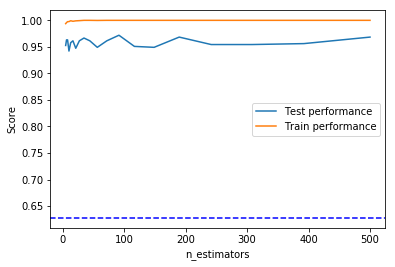

Max test score 0.972


In [156]:
loop(RandomForestClassifier)

We see that both for the test and train accuracy they both outperform the baseline accuracy of 0.63. The train score has an accuracy at 1 after only a few estimators are added while the out-of-sample testing provides a max test score of 0.97

## Exercise 3
### Exercise 3.1.2

We import the wine dataset and ready the data for modelling.

In [74]:
#PREAMBLE
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.datasets import load_digits

# Get wine data
data_wine = load_wine()
X_wine = data_wine['data']
y_wine = data_wine['target']

# Get digits data
data_digits = load_digits()
X_digits = data_digits['data']
y_digits = data_digits['target']

Next, we follow the answer from **Exercise 3.1.1 Kristians version**. 

In [75]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler


class kPCA:
    def __init__(self, k  = None):
        self.ssc = StandardScaler()
        self.k = k 
        self.W = None 
        self.explained_variance = None 
        self.pc_cov_mat = None
    
        
    def fit(self, X):
        if self.k is None:
            self.k = X.shape[1]
            
        self.ssc.fit(X)
        X_std = self.ssc.transform(X)
        cov_mat = np.cov(X_std.T)
        
        eig_vals, eig_vecs = np.linalg.eig(cov_mat)
        top_k_eigen_vecs = self._find_top_vecs(eig_vals, eig_vecs)
        
        self.W = np.hstack([
            w.reshape(-1,1) for w in top_k_eigen_vecs
        ])
        
        return self
            
    
    def _find_top_vecs(self, eigen_values, eigen_vectors):
        pairs = zip(abs(eigen_values), eigen_vectors.T)
        sortedpairs = sorted(pairs, key = lambda pair: pair[0], reverse = True)
        eigen_values, eigen_vectors = zip(*sortedpairs)
        return eigen_vectors[:self.k]
        
    
    def transform(self, X):
        X_std = self.ssc.transform(X)
        pc = np.dot(X_std, self.W)
        
        # Compute explained variance
        var = [np.var(pci) for pci in pc.T]
        total = sum(var)
        self.explained_variance = [i/total for i in var]
        
        return pc

> **Ex. 3.1.2**: Reproduce the figure from the slides that compares PCA, LDA, t-SNE and UMAP as applied to the digits dataset.
1. Do it for the digits dataset (same as in slides)
2. Do it also for the wine dataset. What problems do you observe if you don't standardize the wine dataset? Why is this not a problem with the digits data?
3. Comment on the differences you observe as well as the applicability (and necessity thereof) of different methods for different data.
>
> *Hint: You can use [this class](https://github.com/ulfaslak/ulf_pytools/blob/7f4f1eb7e2d721851c8dacb20904478b19090f2a/ulf.py#L451) for making coloring easier. It lets you create a function that takes a category as input and returns an associated color. Read the docstring for usage example.*

In [92]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from umap import UMAP

In [97]:
#Dimensions reducer with standardscaler
def PlotDimensionsReducer(reducer, X, y, ax):
    ssc = StandardScaler()
    X_std = ssc.fit_transform(X)
    
    if reducer == LDA:
        dmap = reducer().fit_transform(X_std, y)
    else:
        dmap = reducer().fit_transform(X_std)
    
    d1, d2 = dmap[:,0], dmap[:,1]
    
    sct = ax.scatter(d1,d2, c= y, cmap = 'autumn')
    ax.set_title(reducer.__name__)

C:\Users\bjorn\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


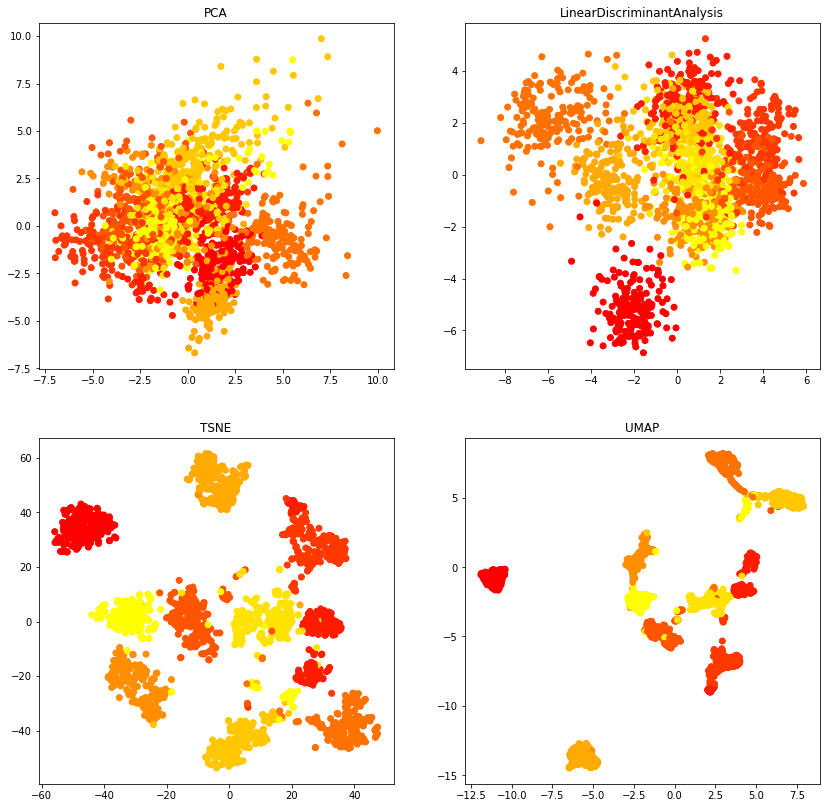

In [98]:
fig, ax = plt.subplots(2,2, figsize = (14,14))
#Digits dataset STANDARDIZED
PlotDimensionsReducer(PCA, X_digits, y_digits, ax[0][0])
PlotDimensionsReducer(LDA, X_digits, y_digits, ax[0][1])
PlotDimensionsReducer(TSNE, X_digits, y_digits, ax[1][0])
PlotDimensionsReducer(UMAP, X_digits, y_digits, ax[1][1])


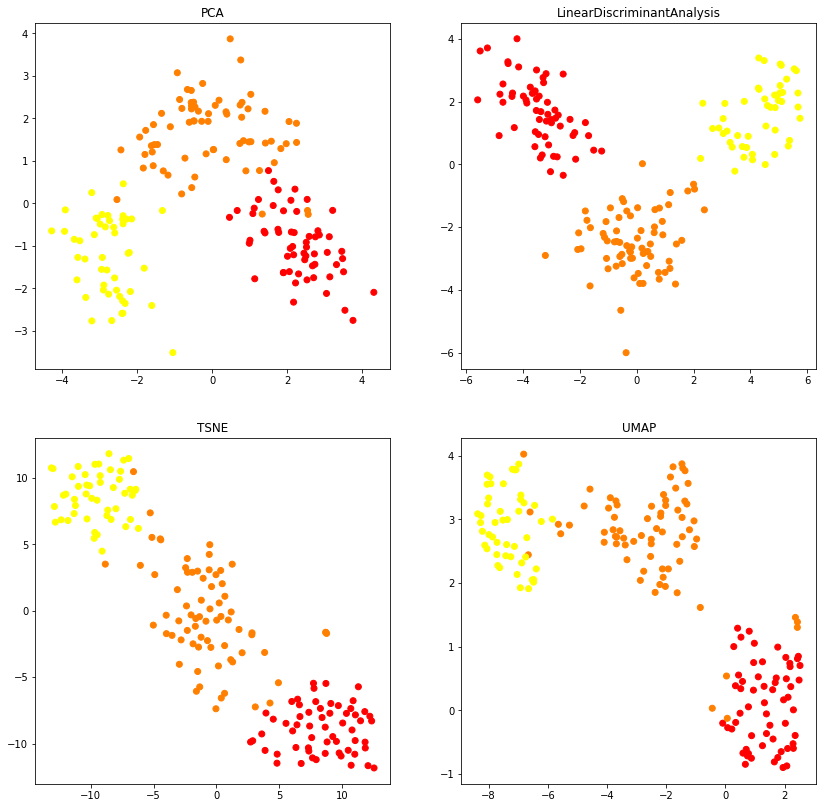

In [99]:
fig, ax = plt.subplots(2,2, figsize = (14,14))
#Wine dataset STANDARDIZED
PlotDimensionsReducer(PCA, X_wine, y_wine, ax[0][0])
PlotDimensionsReducer(LDA, X_wine, y_wine, ax[0][1])
PlotDimensionsReducer(TSNE, X_wine, y_wine, ax[1][0])
PlotDimensionsReducer(UMAP, X_wine, y_wine, ax[1][1])

In [109]:
def PlotDimensionsReducer_nonstd(reducer, X, y, ax):
    #ssc = StandardScaler()
    #X_std = ssc.fit_transform(X)
    
    if reducer == LDA:
        dmap = reducer().fit_transform(X, y)
    else:
        dmap = reducer().fit_transform(X)
    
    d1, d2 = dmap[:,0], dmap[:,1]
    
    sct = ax.scatter(d1,d2, c= y, cmap = 'winter')
    ax.set_title(reducer.__name__)

C:\Users\bjorn\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


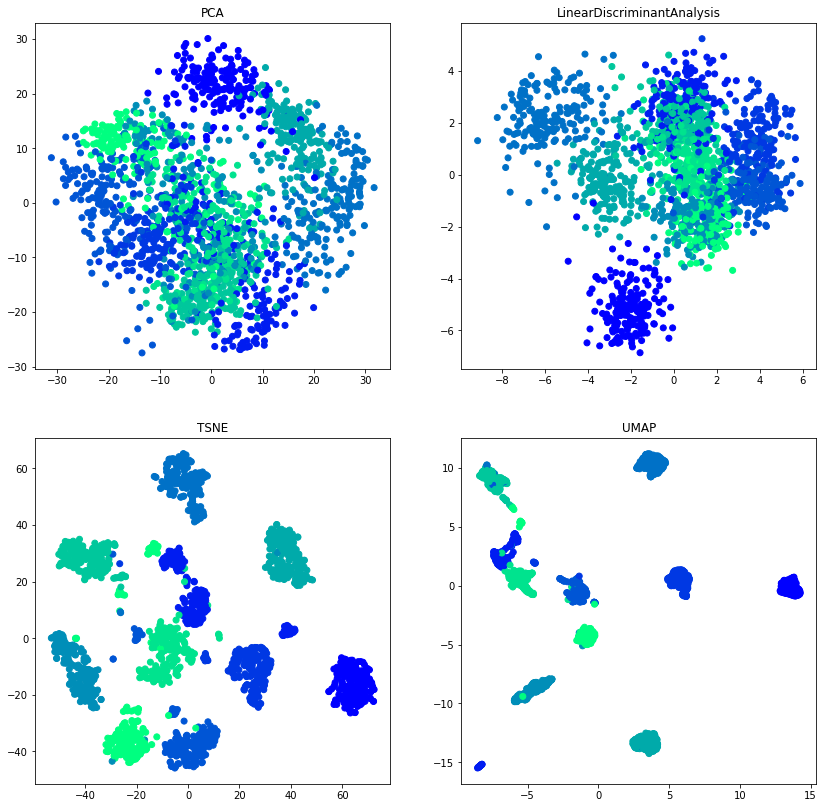

In [111]:
fig, ax = plt.subplots(2,2, figsize = (14,14))
#DIGITS dataset NON-STANDARDIZED
PlotDimensionsReducer_nonstd(PCA, X_digits, y_digits, ax[0][0])
PlotDimensionsReducer_nonstd(LDA, X_digits, y_digits, ax[0][1])
PlotDimensionsReducer_nonstd(TSNE, X_digits, y_digits, ax[1][0])
PlotDimensionsReducer_nonstd(UMAP, X_digits, y_digits, ax[1][1])

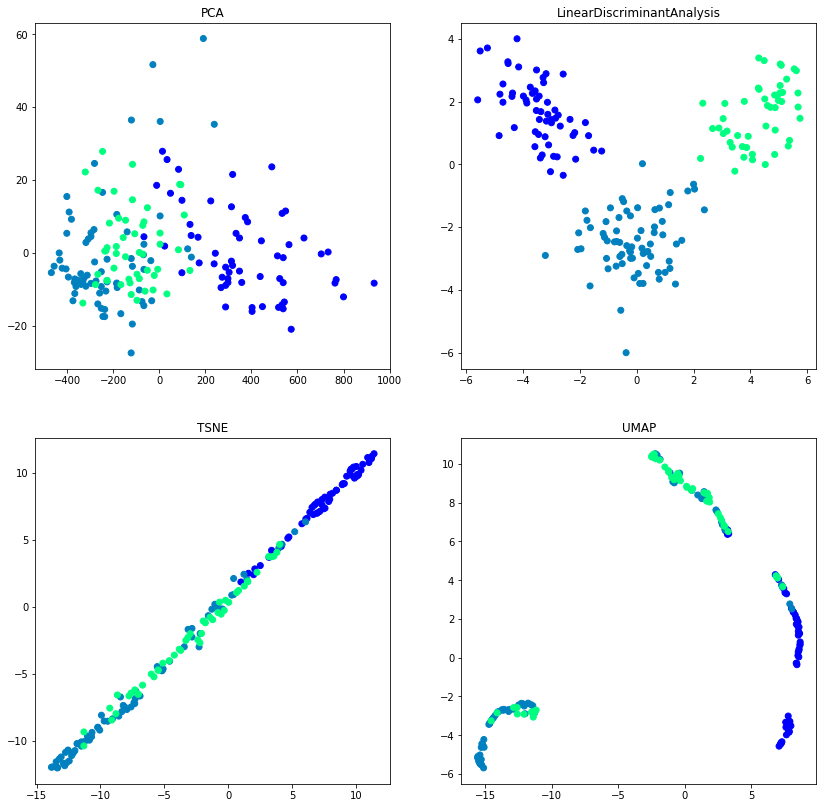

In [112]:
fig, ax = plt.subplots(2,2, figsize = (14,14))
#Wine dataset NON-STANDARDIZED
PlotDimensionsReducer_nonstd(PCA, X_wine, y_wine, ax[0][0])
PlotDimensionsReducer_nonstd(LDA, X_wine, y_wine, ax[0][1])
PlotDimensionsReducer_nonstd(TSNE, X_wine, y_wine, ax[1][0])
PlotDimensionsReducer_nonstd(UMAP, X_wine, y_wine, ax[1][1])

We can observe that the linear dimensionality reductions are not greatly affected by whether or not we first standardize the data before performing the dimensions reduction. However, if we do not standardize our data before perming the non-linear dimensionality reductions (TSNE and UMAP) there is not a significant difference in the digits data set with vs without standardization. However, there is a significant (visual) difference in the wine data set for non-standardized vs standardized non-linear dimension reduction, i.e. for TSNE and UMAP.
This could imply that there is an inherent standardization in the digits data and that it is not the case for the wine data.
To visualize this we can plot the histogram for each data set.

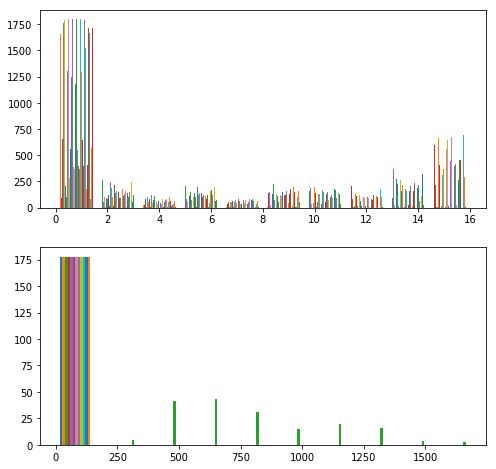

In [118]:
fig, (ax1, ax2) = plt.subplots(2,figsize = (8,8))
ax1.hist(X_digits)
ax2.hist(X_wine)
plt.show()

As we see can see from the graphs, the digits data is organized between the integer values of 0 to 16. For the wine data there is a huge spread from 0 up to approximately 1750. Therefore, foregoing standardization of the wine data will lead to imprecise results in both the linear and non-linear dimensionality reduction, however much more the case for the latter part.